# Bitmex Top 10 level feed

## Read data, 08:00-10:00

In [1]:
import datetime, dateutil
import numpy as np
import gzip
import pickle
from matplotlib import pyplot as plt
isoparse = dateutil.parser.isoparse

def read_file_lob(src, is_gzip=False):
    def load_archive(hnd):
        data = []
        try:
            while True:
                dd = pickle.load(f)
                dd = dd['data'][0]
                if int(dd['timestamp'][11:13]) < 9:
                    pass
                else:
                    if int(dd['timestamp'][11:13]) > 12:
                        return data
                    tpl = [dd['timestamp'], dd['bids'], dd['asks']]
                    data.append(tpl)
        except EOFError:
            print('End of File')
        return data
    
    if is_gzip:
        with gzip.open(src, 'rb') as f:
            return load_archive(f)
    else:
        with open(src, 'rb') as f:
            return load_archive(f)

In [2]:
src = r"C:\temp\bitmexdata\2021-04-02%XBTUSD%orderBook10.pklgz"    
data = read_file_lob(src, is_gzip=True)

In [3]:
tstamp = [isoparse(x[0]) for x in data]

SCNDS = datetime.timedelta(seconds=1)
def sec_elapsed(t0, t):
    return (t - t0) / SCNDS

tstamp0 = tstamp[0]
tstamp = np.array([sec_elapsed(tstamp0, t) for t in tstamp])

bb = np.array([x[1] for x in data])
bo = np.array([x[2] for x in data])
mid = 0.5*(bb[:,0,0] + bo[:,0,0])
sprd = bo[:,0,0] - bb[:,0,0]
bbo_size = (bb[:,0,1] + bo[:,0,1])
bbo_imb = bb[:,0,1] / bbo_size

### Plot LOB during state changes

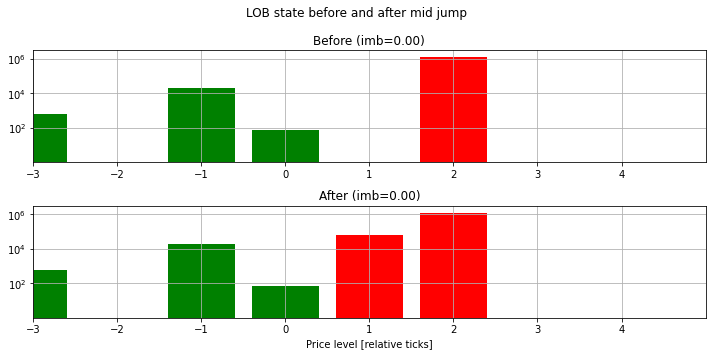

In [4]:
## Mid change
ipre = np.diff(mid).nonzero()[0]
## Mid change + BB change + BO change
#ipre = ((np.diff(mid) != 0) & (np.diff(bb[:,0,0]) != 0.0) & (np.diff(bo[:,0,0]) != 0.0)).nonzero()[0]

ipost = ipre + 1 # compare with following data point.

j = 70 # Pick which observation to view.
t0 = ipre[j]
t1 = ipost[j]

price_offset = mid[t0]


ticksize = 0.5
bb_ref = bb[t0, 0, 0]
def norm_bid(prices):
    return (prices - bb_ref) / ticksize

bo_ref = bo[t0, 0, 0]
def norm_ask(prices):
    return (prices - bb_ref) / ticksize

fig, axs = plt.subplots(2,1, figsize=(10,5), sharex=False)
axs[0].bar(norm_bid(bb[t0, :, 0]), bb[t0, :, 1], color='g')
axs[0].bar(norm_ask(bo[t0, :, 0]), bo[t0, :, 1], color='r')
axs[1].bar(norm_bid(bb[t1, :, 0]), bb[t1, :, 1], color='g')
axs[1].bar(norm_ask(bo[t1, :, 0]), bo[t1, :, 1], color='r')

rel_imb = bbo_imb[t0], bbo_imb[t1]


lbound = min(norm_bid(bb[t0, :, 0]).max(), norm_bid(bb[t1, :, 0]).max())
ubound = max(norm_bid(bo[t0, :, 0]).min(), norm_bid(bo[t1, :, 0]).min())

for ax in axs:
    #ax.set_xlim([-4, 5 + max(sprd[t0], sprd[t1])/ticksize])
    ax.set_xlim([lbound-3, ubound+3])
    ax.set_yscale('log')
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end, 1))
    ax.grid()
fig.suptitle('LOB state before and after mid jump')
axs[0].set_title(f'Before (imb={rel_imb[0]:.2f})')
axs[1].set_title(f'After (imb={rel_imb[1]:.2f})')
axs[1].set_xlabel('Price level [relative ticks]')
fig.tight_layout()

In [5]:
print(bb[t0-1, 0, 0], bo[t0-1, 0, 0])
print(bb[t0, 0, 0], bo[t0, 0, 0])
print(bb[t1, 0, 0], bo[t1, 0, 0])

59499.5 59500.5
59499.5 59500.5
59499.5 59500.0


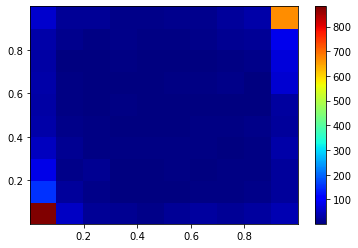

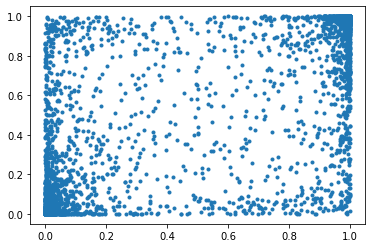

In [6]:
fig, ax = plt.subplots()
h = ax.hist2d(bbo_imb[ipre], bbo_imb[ipost], bins=10, density=False, cmap=plt.cm.jet)
fig.colorbar(h[3], ax=ax)

plt.figure()
plt.scatter(bbo_imb[ipre], bbo_imb[ipost], marker='.')

## Convert full LOB to relative (maybe not needed)

In [7]:
bb_rel = np.zeros_like(bb[:,:,0])

def lob_relative(lob, nmax=10, ticksize=0.5):
    ntick = int(1/ticksize)
    
    new_arr = np.zeros((lob.shape[0], nmax))
    for t in range(len(lob)):
        prices = lob[t,:,0]
        volumes = lob[t,:,1]
        priceIdx = np.abs(prices - prices[0])*ntick # price to ticks
        priceIdx = priceIdx.astype(int)
        idx = (priceIdx < nmax).nonzero()
        new_arr[t, priceIdx[idx]] = volumes[idx]
    return new_arr

# Align levels to ticks away from BBO, i.e volumes at 0 1 2 3 ticks away from top of book.
bb_rel = lob_relative(bb)
bo_rel = lob_relative(bo)

## Plot Cummulative LOB

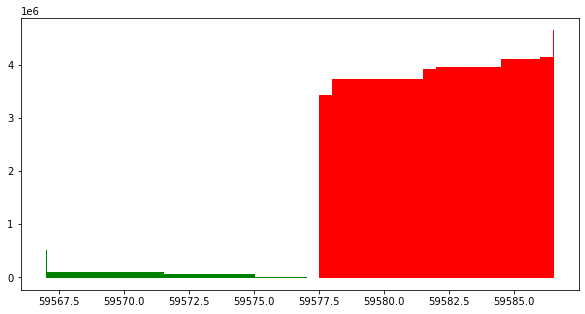

In [8]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10,5))
plt.fill_between(bb[0, :, 0], bb[0, :, 1][::-1].cumsum(), color='g', step='post')
plt.fill_between(bo[0, :, 0], bo[0, :, 1].cumsum(), color='r', step='post')
#plt.xlim([mid[0]-5, mid[0]+5])

## Replay LOB

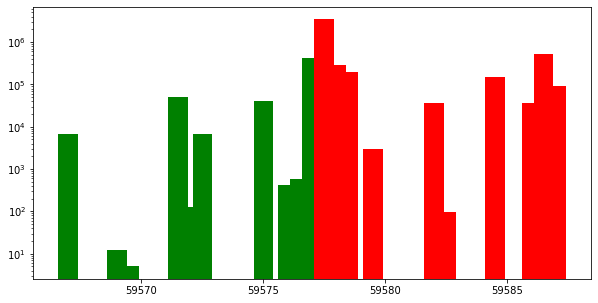

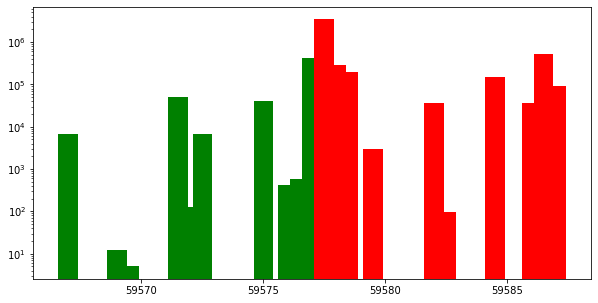

In [9]:
%matplotlib inline
import time
import pylab as pl
from IPython import display
plt.figure(figsize=(10,5))

for i in range(5):
    plt.clf()
    plt.bar(bb[i, :, 0], bb[i, :, 1], color='g')
    plt.bar(bo[i, :, 0], bo[i, :, 1], color='r')
    plt.yscale('log')
    display.clear_output(wait=True)
    display.display(pl.gcf())
    time.sleep(0.1)
plt.show()

## Read Trades

In [10]:
import datetime, dateutil
import numpy as np
import gzip
import pickle
from matplotlib import pyplot as plt
isoparse = dateutil.parser.isoparse

def read_file_trades(src, is_gzip=False):
    def load_archive(hnd):
        data = []
        try:
            while True:
                dd = pickle.load(f)
                if int(dd['timeReceived'][11:13]) < 9:
                    pass
                else:
                    if int(dd['timeReceived'][11:13]) > 12:
                        return data
                    for trd in dd['data']:
                        subset = {key:trd.get(key) for key in ['timestamp', 'side', 'size', 'price', 'tickDirection']}
                        data.append(subset)
        except EOFError:
            print('End of File')
        return data
    
    if is_gzip:
        with gzip.open(src, 'rb') as f:
            return load_archive(f)
    else:
        with open(src, 'rb') as f:
            return load_archive(f)

In [11]:
src = r"C:\temp\bitmexdata\2021-04-02%XBTUSD%trade.pklgz"
trades = read_file_trades(src, is_gzip=True)

import pandas as pd
df_trds = pd.DataFrame(trades)
df_trds['timestamp'] = pd.to_datetime(df_trds['timestamp'])
df_trds['time'] = (df_trds['timestamp'].dt.tz_localize(None) - tstamp0.replace(tzinfo=None)) / pd.Timedelta('1s')

df_trds['size'] = np.where(df_trds['side']=='Buy', df_trds['size'], -df_trds['size'])
df_trds.drop(inplace=True, columns=['side'])
#import dateutil
#isoparse = dateutil.parser.isoparse
#for e in trades:
#    e['timestamp'] = isoparse(e['timestamp']).replace(tzinfo=None)

In [12]:
df_trds['bb'] = np.where(df_trds['size']<0, df_trds['price'], np.nan)
#df_trds['bb'] = df_trds['bb'].fillna(method='ffill')
df_trds['bo'] = np.where(df_trds['size']>0, df_trds['price'], np.nan)
#df_trds['bo'] = df_trds['bo'].fillna(method='ffill')

In [13]:
mb_mask = df_trds['size'] > 0
ms_mask = df_trds['size'] < 0

<AxesSubplot:>

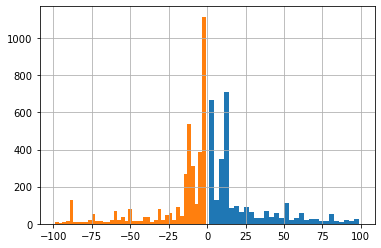

In [14]:
plt.figure()
df_trds[ (df_trds['size'] >0) & (df_trds['size'] < 100) ]['size'].hist(bins='auto')
df_trds[ (df_trds['size'] <0) & (df_trds['size'] > -100) ]['size'].hist(bins='auto')
#plt.xlim([-5000, 5000])

In [15]:
df_trds['bb_id'] = (df_trds[ df_trds['size'] < 0 ]['price'].diff() != 0.0).cumsum().astype(int)
df_trds['bo_id'] = (df_trds[ df_trds['size'] > 0 ]['price'].diff() != 0.0).cumsum().astype(int)

In [16]:
df_trds[df_trds['size'] > 0].groupby(['bo_id'])
#TODO: group by bo_id, sum to get total volume transacted, match with LOB.

In [17]:
#plt.step(tstamp, bb[:,0,1])
#plt.step(df_trds[mb_mask]['time'], df_trds[mb_mask]['size'].cumsum())